In [151]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

In [152]:
working_dir = os.getcwd()
windowsize = 1
epochs = 100

In [153]:
def read_training_data():
    df = pd.read_csv(f"{working_dir}/../data/TrainData.csv", sep=',')
    windspeed_training = df["WS10"].to_numpy().reshape((-1, 1))
    power_training = df["POWER"].to_numpy()
    u = df["U10"].to_numpy()
    v = df["V10"].to_numpy()
    wind_direction_training = np.mod(180 + np.rad2deg(np.arctan2(v, u)), 360)

    return windspeed_training, power_training, wind_direction_training


def read_input_data():
    df = pd.read_csv(f"{working_dir}/../data/WeatherForecastInput.csv", sep=',')
    windspeed_input = df["WS10"].to_numpy().reshape((-1, 1))
    u_input = df["U10"].to_numpy()
    v_input = df["V10"].to_numpy()
    direction_input = np.mod(180 + np.rad2deg(np.arctan2(v_input, u_input)), 360).reshape((-1, 1))
    windspeed_and_direction_input = np.concatenate((windspeed_input, direction_input), axis=1)

    return windspeed_input, direction_input, windspeed_and_direction_input

def read_solution():
    df = pd.read_csv(f"{working_dir}/../data/Solution.csv", sep=',')
    actual_power = df["POWER"].to_numpy()
    timestamp = df["TIMESTAMP"].to_numpy()

    return actual_power, timestamp

In [154]:
def create_timeseries(powers, windowsize):
    rows = len(powers) - windowsize
    x = np.zeros((rows, windowsize))
    y = np.zeros(rows)

    for i in range(rows):
        for j in range(windowsize):
            x[i][j] = powers[i + j]

        y[i] = powers[i + windowsize]

    return x, y

In [155]:
training_data = read_training_data()
windspeed_training = training_data[0]
power_training = training_data[1]

input_data = read_input_data()
windspeed_input = input_data[0]
wind_direction = input_data[1]
windspeed_and_direction_input = input_data[2]

solution = read_solution()
actual_power = solution[0]
timestamp = solution[1]

In [156]:
x, y = create_timeseries(power_training, windowsize)
forecast_input = create_timeseries(actual_power, windowsize)[0]

In [157]:
def regression(x, y, model, forecast_input, actual_power, windowsize):
    # Train model
    model.fit(x, y)
    # Predict using trained model
    y_pred = model.predict(forecast_input)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred))

    # Return the results of RMSE and the predicted power
    return y_pred, rmse

In [158]:
def ann_model(x, y, forecast_input, actual_power, windowsize, epochs):
    # Process Variables
    scaler = MinMaxScaler()
    X = scaler.fit_transform(x)

    input = scaler.transform(forecast_input)

    # Create Model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Train model
    model.fit(X, y, epochs=epochs, batch_size=32)

    # Predict using trained model
    y_pred_scaled = model.predict(input)

    y_pred_ann = scaler.inverse_transform(y_pred_scaled)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred_ann))

    return y_pred_ann, rmse

In [159]:
def rnn_model(x, y, forecast_input, actual_power, windowsize, epochs):
    # Process Variables
    scaler = MinMaxScaler()
    X = scaler.fit_transform(x)

    input = scaler.transform(forecast_input)

    # Create Model
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1, windowsize), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

     # Train model
    model.fit(X, y, epochs=epochs, batch_size=32)

    # Predict using trained model
    y_pred_scaled = model.predict(input)

    y_pred_rnn = scaler.inverse_transform(y_pred_scaled)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred_rnn))

    return y_pred_rnn, rmse

In [160]:
# Regressions
lr = regression(x, y, LinearRegression(), forecast_input, actual_power, windowsize)
svr = regression(x, y, SVR(), forecast_input, actual_power, windowsize)

# Neural Networks
ann = ann_model(x, y, forecast_input, actual_power, windowsize, epochs)
rnn = rnn_model(x, y, forecast_input, actual_power, windowsize, epochs)

# Print results
print(f"{'RMSE for LR model:':<20}{lr[1]}")
print(f"{'RMSE for SVR model:':<20}{svr[1]}")
print(f"{'RMSE for ANN model:':<20}{ann[1]}")
print(f"{'RMSE for RNN model:':<20}{rnn[1]}")

Epoch 1/100
503/503 [==============================] - 3s 3ms/step - loss: 0.0455 - root_mean_squared_error: 0.2134
Epoch 2/100
503/503 [==============================] - 1s 2ms/step - loss: 0.0116 - root_mean_squared_error: 0.1076
Epoch 3/100
503/503 [==============================] - 1s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 4/100
503/503 [==============================] - 1s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1074
Epoch 5/100
503/503 [==============================] - 1s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071
Epoch 6/100
503/503 [==============================] - 1s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 7/100
503/503 [==============================] - 1s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1073
Epoch 8/100
503/503 [==============================] - 1s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 9/100
503/503 [==============================] - 1s 2ms/step - los

In [ ]:
# Save Results to Files
forecast_template = pd.read_csv(f'{working_dir}/../data/ForecastTemplate.csv')

# LR forecast template output
forecast_template['FORECAST'] = lr[0]
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-LR.csv', index=False)

# SVR forecast template
forecast_template['FORECAST'] = svr[0]
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-SVR.csv', index=False)

# ANN forecast template
forecast_template['FORECAST'] = ann[0]
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-ANN.csv', index=False)

# RNN forecast template
forecast_template['FORECAST'] = rnn[0]
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-RNN.csv', index=False)

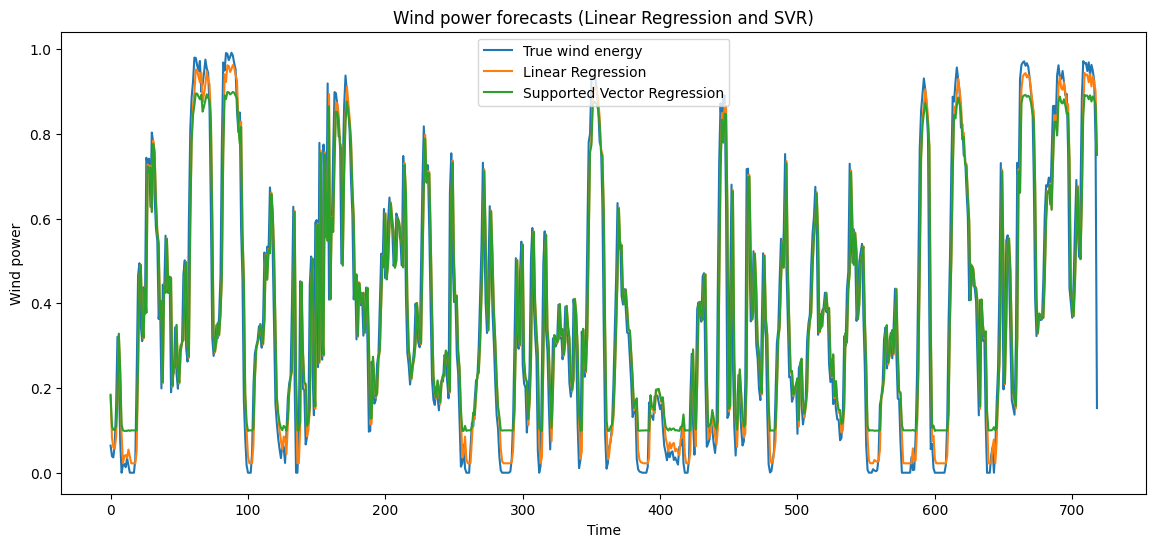

In [ ]:
# Plot the time-series figure for LR and SVR
plt.figure(figsize=(14, 6))
plt.plot(actual_power[windowsize:], label="True wind energy")
plt.plot(lr[0], label="Linear Regression")
plt.plot(svr[0], label="Supported Vector Regression")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (LR and SVR)")
plt.legend()
plt.show()

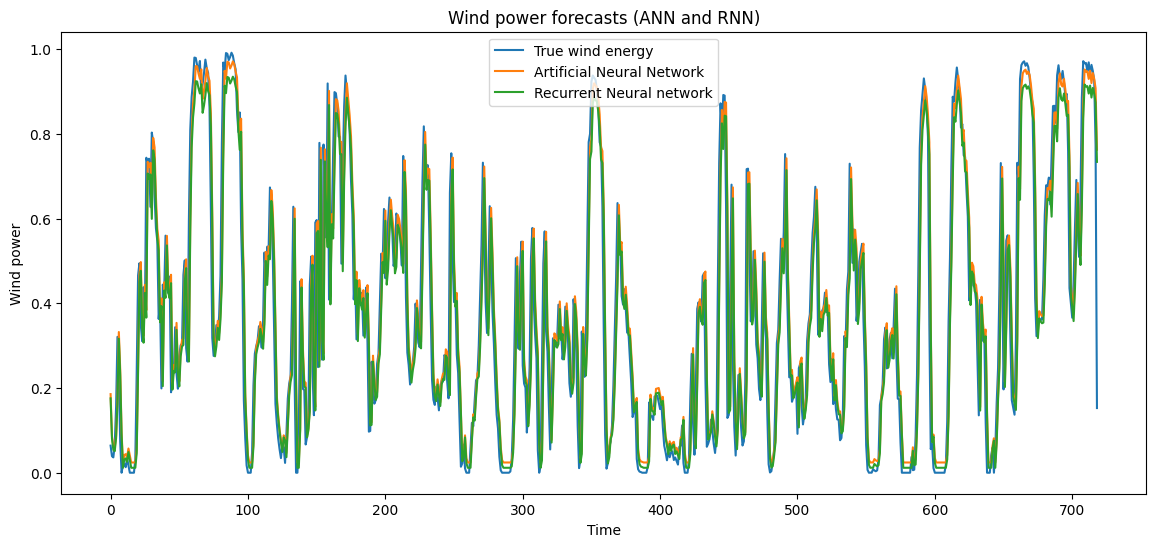

In [ ]:
# Plot the time-series figure for ANN and RNN
plt.figure(figsize=(14, 6))
plt.plot(actual_power[windowsize:], label="True wind energy")
plt.plot(ann[0], label="Artificial Neural Network")
plt.plot(rnn[0], label="Recurrent Neural network")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (ANN and RNN)")
plt.legend()
plt.show()

In [ ]:
# Table for Results

table_data = [lr[0], svr[0], ann[0], rnn[0]]